# TODO fase 1
 - calculate predictions for a stock fx apple
 - statistics for the predictions: distribution of errors, percentage prediction with the right direction:  close>open, open<close
 - visualize ohlc as bands and on stock curve
 - split in train, test so that test data are taken from time periodens after the training data and possibly from stocks that have not been used for training 

 - tjek quantile objective function
 - objectiv function that weigh open and closing prices higher

 - add day of week to training data
                                                                                                                 
                                                                                                                 
# TODO fase 2
 - language modelling

# DONE 
 - speed up training: improve the pandas part by 30 to 60 times


In [ ]:
#default_exp finance.train

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# export
from lib.data.lists import *
from lib.finance.data import *
from pathlib import Path

import pandas as pd
import numpy as np

#import matplotlib.pyplot as plt

# Import the main functionality from the SimFin Python API.
import simfin as sf

# Import names used for easy access to SimFin's data-columns.
from simfin.names import *

In [ ]:
# Version of the SimFin Python API.
sf.__version__

'0.8.1'

# Load data


In [ ]:
df_prices, stocks, validStocks, inValidStocks = prepareSimFinData()

dataPath:/Users/kasparlund/simfin_data exists:True
Dataset "us-shareprices-daily" on disk (21 days old).
- Loading from disk ... Done!
number of stocks:         2615
number of valid stocks:   2033
number of invalid stocks: 582
smallest pricelines pr stock: Ticker
NLN      1
WMG      2
SSI     17
GAMZ    18
PCP     24
dtype: int64
longest pricelines pr stock:  Ticker
HTH    3379
HT     3379
HSY    3379
HST    3379
KBR    3379
dtype: int64


In [ ]:
#statistics on the mature stocks
df_prices.loc[validStocks,[PREV_CLOSE,OPEN,HIGH,LOW,CLOSE]].describe(percentiles=[0.0002, 0.25, 0.75, 0.9998])        

,previous_close,Open,High,Low,Close
count,5.452814e+06,5.452814e+06,5.452814e+06,5.452814e+06,5.452814e+06
mean,1.645078e+02,2.178618e-04,1.649711e-02,-1.613212e-02,5.501282e-04
std,4.979344e+03,1.652678e-02,2.697750e-02,2.462773e-02,2.928071e-02
min,2.000000e-02,-5.000000e-01,-4.800989e-01,-5.000000e-01,-5.000000e-01
0.02%,6.000000e-02,-2.137199e-01,-1.561031e-01,-3.292862e-01,-2.703173e-01
25%,1.520000e+01,-3.935865e-03,3.807107e-03,-2.225379e-02,-1.051304e-02
50%,2.957000e+01,0.000000e+00,1.079417e-02,-1.064184e-02,0.000000e+00
75%,5.393000e+01,4.559025e-03,2.192243e-02,-3.395201e-03,1.118881e-02
99.98%,2.162699e+05,2.282198e-01,4.400000e-01,1.520392e-01,3.332735e-01
max,3.449700e+05,1.407407e+00,1.477419e+00,1.210095e+00,1.421652e+00


In [ ]:
#normalization_faktor = 2.697750e-02
#TODO add normalized datacolumn to df_prices indstead of replacing them
normalized_prefix="normalized_"
[NORM_OPEN,NORM_HIGH,NORM_LOW,NORM_CLOSE] = [normalized_prefix+OPEN,\
                                             normalized_prefix+HIGH,\
                                             normalized_prefix+LOW,\
                                             normalized_prefix+CLOSE]

#use tanh to squeez the data range
def normalizeData( df_prices, columns, normalization_faktor=2.7e-02, normalized_prefix=normalized_prefix):
    #normalize the training data
    if not normalization_faktor==1.0 :
        normalized_columns = ["normalized_"+ name for name in columns]
        #df_prices[normalized_columns] = np.tanh(8*df_prices[columns].values)
        df_prices[normalized_columns] = np.tanh(14*np.log1p(df_prices[columns].values))
    return df_prices,normalized_columns


In [ ]:
import torch
import torch.nn as nn
class OHLCDatasetClose(OHLCDataset):
    #x, y significes input vs output
    def __init__(self, df_prices, stocks, column_names, seq_length): 
        super().__init__(df_prices, stocks, column_names, seq_length)
        
    def __getitem__(self, index):
        #pt: price target
        #pi: price input
        ix = self.idx_seq[index,:]        
        pi = torch.tensor( self.np_prices[ix[1]:ix[0]] )
        pt = torch.tensor( self.np_prices[ix[0]:ix[0]+1] )
        return pi, pt #, index


In [ ]:
%%time 

from lib.learner.learner import*
from lib.learner.optimizers import*
from lib.model.model import*
from lib.model.modelmanager import*
import torch.nn as nn

seq_length = 360 #
#seq_length = 64
#each priceline has 4 datapoint:[OPEN,LOW,HIGH,CLOSE]
#batchsize is the number of stocks processed in parallel
#seq_length is the number of input days og stock priced used to estimate the next days prices
training_column_names = [OPEN,CLOSE]#[OPEN,HIGH,LOW,CLOSE] #[OPEN,#CLOSE]
df_prices, training_column_names = normalizeData(df_prices,training_column_names)

ohlc_ds = OHLCDatasetClose(df_prices, stocks=validStocks, column_names=training_column_names, seq_length=seq_length)
ohlc_ds.initializeSquenzing()

print(f"training columns = {training_column_names}")

train_ds, test_ds = ohlc_ds.split2train_test(0.25)
print(f"number of stocks, train stocks, test stocks: {len(ohlc_ds.stocks)}, {len(train_ds.stocks)}, {len(test_ds.stocks)}")

databunch = DataBunch(train_ds.dataloader(batch_size=2048, shuffle=True,  drop_last=True), \
                      test_ds.dataloader( batch_size=4096, shuffle=False, drop_last=False), \
                      c_in=len(ohlc_ds.column_names), c_out=len(ohlc_ds.column_names))

#batch = next(iter(databunch.train_dl))
#batch[0].dtype, batch[0].shape, view(batch[0]).shape

%time l = [len(b[0]) for b in databunch.train_dl]

#print("the following lengths must be the same")
#%time stock_days = [len(ohlc_ds.stock_grps.get_group(stock)) for stock in ohlc_ds.stocks]
#print(len(ohlc_ds), sum(stock_days)-len(stock_days)*(seq_length+1))

training columns = ['normalized_Open', 'normalized_Close']
number of stocks, train stocks, test stocks: 2033, 1525, 508
CPU times: user 1min 5s, sys: 1.65 s, total: 1min 7s
Wall time: 1min 6s
CPU times: user 1min 11s, sys: 2.85 s, total: 1min 14s
Wall time: 1min 14s


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import partial
from lib.model.model import *

#torch.nn.Tanh(), torch.nn.ReLU(inplace=False), #     torch.nn.Tanh(), #nn.LeakyReLU(inplace=True), #
"""
        self.blocks = [ nn.Sequential( 
                        *[   torch.nn.BatchNorm1d(1),
                            activ_func,
                            nn.Linear(in_dim,w),
                          
                            torch.nn.BatchNorm1d(1),
                            activ_func,
                            nn.Linear(w,w),
                            
                            torch.nn.BatchNorm1d(1),
                            activ_func,
                            nn.Linear(w,out_dim),
                         ] )
                         for w in widths
                      ]
"""
class Block(nn.Sequential):
    def __init__(self, in_dim, width, activ_func=torch.nn.Tanh(), dropout_ratio=0.0):
        super().__init__(
                            torch.nn.BatchNorm1d(1),
                            activ_func,
                            nn.Dropout(p=dropout_ratio, inplace=False),
                            nn.Linear(in_dim,width),
                          
                            torch.nn.BatchNorm1d(1),
                            nn.Dropout(p=dropout_ratio, inplace=False),
                            activ_func,
                            nn.Linear(width,in_dim),
                            )
        
class DenseResBlock(nn.Module):
    def __init__(self, in_dim, widths, activ_func=torch.nn.Tanh(), dropout_ratio=0.0):
        super().__init__()
        #widths = [int(in_dim/16+0.5), int(in_dim/8+0.5), int(in_dim/4+0.5), int(in_dim/2+0.5), in_dim]
        self.block_1 = Block(in_dim, widths[0], activ_func, dropout_ratio)
    def forward(self,x):
        """
        r = x 
        for b in self.blocks:r = r + b(x)
        return r        
        """
        #return self.block_1(x)+self.block_2(x)+self.block_3(x)
        return self.block_1(x)

class Stem(nn.Sequential):
    def __init__(self, seq_length, embedding_width, res_in_dim, activ_func=torch.nn.Tanh(), dropout_ratio=0.0 ):
        super().__init__(
                        nn.Linear(seq_length,embedding_width),
    
                        torch.nn.BatchNorm1d(1),
                        nn.Dropout(p=dropout_ratio, inplace=False),
                        activ_func, 
                        nn.Linear(embedding_width,embedding_width),
    
                        torch.nn.BatchNorm1d(1),
                        nn.Dropout(p=dropout_ratio, inplace=False),
                        activ_func, 
                        nn.Linear(embedding_width,res_in_dim)
            )
    
class DenseResNetModel(nn.Module):
    def __init__(self, seq_length, embedding_width, nb_res, res_in_dim, res_block_widths=[], activ_func=torch.nn.Tanh(), dropout_ratio=0.0 ):
        super().__init__()
        self.stem_1 = Stem(seq_length, embedding_width, res_in_dim, activ_func, dropout_ratio)
        self.stem_2 = Stem(seq_length, embedding_width, res_in_dim, activ_func, dropout_ratio)
        self.stem_3 = Stem(seq_length, embedding_width, res_in_dim, activ_func, dropout_ratio)
        #self.stem_4 = Stem(seq_length, embedding_width, res_in_dim, activ_func, dropout_ratio)
        #self.stem_5 = Stem(seq_length, embedding_width, res_in_dim, activ_func, dropout_ratio)
        
        blocks = [DenseResBlock(res_in_dim, res_block_widths, activ_func, dropout_ratio) 
                  for i in np.arange(nb_res)]
        self.resblocks = nn.Sequential(*blocks)
    
        self.fadeout = nn.Sequential(
            torch.nn.BatchNorm1d(1),
            activ_func,
    
            nn.Linear(in_dim,1),
            nn.Flatten()
            )
        
    def forward(self,x):
        x_stem      = self.stem_1(x)+self.stem_2(x)+self.stem_3(x)
        #x_stem      = self.stem_1(x)+self.stem_2(x)+self.stem_3(x)+self.stem_4(x)+self.stem_5(x)
        #x_stem      = self.stem_1(x)+self.stem_2(x)+self.stem_3(x)+self.stem_4(x)
        #x_stem      = self.stem_1(x)
        #x_stem      = self.stem_1(x)+self.stem_2(x)+self.stem_3(x)
        x_resblocks = self.resblocks(x_stem)
        x_fadeout   = self.fadeout(x_resblocks)
        return x_fadeout        

# We start by a regressionmodel that predict the next OHLC
 - First try will be the to minimize the squared sum of errors.

In [ ]:
def my_mse_loss(estimate, target): 
    return (estimate-target).square().mean()
def accuracy_sign(estimate, target): 
    return (torch.sgn(estimate[:,0]).eq(torch.sgn(target[:,0]))).float().mean()

len_of_batchsamples = seq_length*len(training_column_names)
print(f"len_of_batchsamples:{len_of_batchsamples}")
tensor_input_view = view_tfm(1,len_of_batchsamples)

sched        = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 
cbfs         = [TrainableModelCallback, TrainEvalCallback, OptimizerCallback, 
                partial(BatchTransformXCallback, tfm = tensor_input_view), 
                Recorder, 
                partial(AvgStatsCallback,[accuracy_sign]),
                ProgressCallback
               ]

len_of_batchsamples:720


In [ ]:
#widths = [int(in_dim/4+0.5), int(in_dim/2+0.5), in_dim, 2*in_dim]
#widths = [int(in_dim/16+0.5), int(in_dim/8+0.5), int(in_dim/4+0.5), int(in_dim/2+0.5), in_dim]
#widths = [in_dim, in_dim, in_dim, in_dim, in_dim]
#widths = [int(in_dim/8+0.5), int(in_dim/4+0.5), int(in_dim/2+0.5), in_dim]
embedding_width = 300  
in_dim = embedding_tail  = 32
nb_res = 2
dropout_ratio=0.3
widths = [in_dim]
model = DenseResNetModel(len_of_batchsamples, embedding_width, nb_res, embedding_tail, widths, 
                         activ_func=torch.nn.Tanh(), dropout_ratio=dropout_ratio )

In [ ]:
%%time

#layer = partial( conv_layer1, stride=1, bn=False, zero_bn=False, act=partial(GeneralRelu,leak=0.01), dropout_ratio=0.15 )
#layer = partial( conv_layer1, stride=1, bn=False, zero_bn=False, act=GeneralRelu, dropout_ratio=0)#dropout_ratio=0.15 )
#mm    = CnnModelManager( get_cnn_model1(layers_sizes, databunch.c_in, databunch.c_out, layer ) )

mm    = CnnModelManager( model )
mm.initialize(is_resnet=False)

xb,_ = mm.getFirstbatch( databunch, normalization = tensor_input_view)
print(f"input shape:{xb.shape}")
#mm.summary(xb, print_mod=False)

input shape:torch.Size([2048, 1, 720])
CPU times: user 1.07 s, sys: 58.3 ms, total: 1.13 s
Wall time: 525 ms


In [ ]:
#ohlc_ds.df_prices.columns, ohlc_ds.df_prices["normalized_Close"].head()

In [ ]:
#test_ds.idx_seq[:10], train_ds.df_prices.shape, train_ds.np_prices.shape, train_ds.np_prices[:10]

In [ ]:
#opt       = SGD(sched,max_lr=0.1)
#opt       = Adam(sched,max_lr=5e-3, moms=(0.85,0.95), max_wd = 0)#1e-5)#1e-6)
opt       = Adam(sched,max_lr=1e-2, moms=(0.85,0.95), max_wd = 1e-5)#)#1e-6)
loss_func = torch.nn.MSELoss() #torch.nn.SmoothL1Loss(), my_mse_loss #nn.L1Loss()

learn = Learner( mm.model, databunch, loss_func=loss_func)
%time learn.fit(3, opt=opt, cb_funcs=cbfs)

epoch,train_loss,train_accuracy_sign,valid_loss,valid_accuracy_sign,time


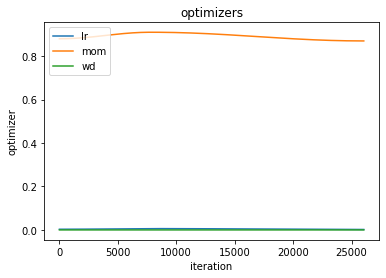

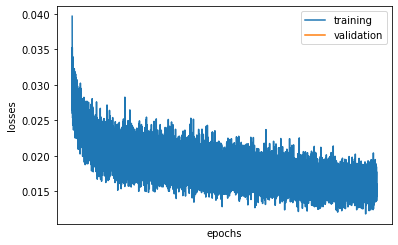

(None, None)

In [ ]:
import matplotlib.pyplot as plt

learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(skip_start=15),plt.show()

In [ ]:
%%time

stocks = test_ds.stocks[:] #"AAPL"
price_targets, prediction_columns = predict_stocks(test_ds, mm, stocks, tensor_input_view )
price_targets.head()

In [ ]:
#statistics on the columns and their predicted values
columns = test_ds.column_names.copy()
columns.extend(prediction_columns)
print(columns)
price_targets.loc[:,columns].describe(percentiles=[0.0002, 0.25, 0.75, 0.9998])        


In [ ]:
#plot signal vs prediction
#AAPL
stock             = stocks[0]
df                = price_targets.loc[stock].iloc[128:256] # extract a section
training_column   = training_column_names[0]
prediction_column = prediction_columns[0]

reference_values  = df[training_column].to_numpy()
prediction_values = df[prediction_column].to_numpy()
dates             = np.arange(len(reference_values))
same_sign         = np.sign(reference_values) == np.sign(prediction_values)

reference_same_sign  = (reference_values[same_sign],  stock+" reference", "blue",  "line")
prediction_same_sign = (prediction_values[same_sign], stock+" prediction","green","circle")
#prediction_opposite_sign = (prediction_values[np.logical_not(same_sign)], stock+" prediction","red","circle")

plotSignalVSPrediction(dates[same_sign],[reference_same_sign,prediction_same_sign])

In [ ]:
df[training_column_names].to_numpy()[:,0].shape

In [ ]:
price_targets.iloc[:10,-5:]

In [ ]:
from math import sqrt
normalization_faktor=2.7e-02
print(sqrt(0.000250), 0.01**2) #0.000295
print(sqrt(0.758663)*normalization_faktor, 0.01**2)


In [ ]:
#mm.model[0][0].weight
#mm.model[0][0].bias

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()